# Imports

In [ ]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

#importazioni per visualizzare immagini
import matplotlib.pyplot as plt
%matplotlib inline


import numpy as np
import pandas as pd
import natsort


import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from PIL import Image, ImageOps, ImageEnhance
import cv2
import torchvision.transforms as tt



import os, math, sys
import time, datetime
import glob, itertools
import argparse, random

import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.models import vgg19
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid

import plotly


from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings("ignore")

In [ ]:
from torch.utils.data import random_split

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Parameters

In [ ]:
# size of the batches for train
batch_size = 4
# size of the batches for test
batch_size_test = 1

# size of image height
img_height = 256
# size of image width
img_width = 256

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# number of residual blocks in generator
n_residual_blocks = 9

transform=tt.Compose([
                      tt.Resize((img_height,img_width)), 
                      tt.RandomCrop((img_height,img_width)),
                      tt.RandomHorizontalFlip(),
                      tt.ToTensor(),
                      tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                      ])

In [ ]:
# Train parameters

# learning rate
lr = 0.0001

# cycle loss weight
lambda_cyc = 10.0

# identity loss weight
lambda_id = 5.0

# epoch to start training from
start_index = 20

# number of epochs of training
epochs = 20


In [ ]:
# Create images and checkpoint directories
dir_images_cyclegan='/content/gdrive/MyDrive/Colab Notebooks/VISIOPE/images_cyclegan'
dir_checkpoint_cyclegan='/content/gdrive/MyDrive/Colab Notebooks/VISIOPE/checkpoint_cyclegan'
os.makedirs("images", exist_ok=True)
os.makedirs("images2", exist_ok=True)

# Dataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, rootA, rootB, transform):
        self.rootA = rootA
        self.rootB = rootB
        self.transform = transform

        self.imgsA = os.listdir(rootA)
        self.imgsB = os.listdir(rootB)
        self.imgsA_len = len(self.imgsA)
        self.imgsB_len = len(self.imgsB)
        self.length_dataset = min(self.imgsA_len, self.imgsB_len) 

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, idx):
        imgA = self.imgsA[idx]
        imgB = self.imgsB[idx]
        
        imgA_path = os.path.join(self.rootA, imgA)
        imgB_path = os.path.join(self.rootB, imgB)

        imageA = Image.open(imgA_path).convert("RGB")
        imageB = Image.open(imgB_path).convert("RGB")

        imageA= self.transform(imageA)
        imageB = self.transform(imageB)

        
        
        return imageA, imageB

In [ ]:
# To show images of dataset
def show_images(dataset):
  output_image = (make_grid(dataset, nrow=2).permute(1, 2, 0).detach().numpy())
  output_image = output_image * 0.5 + 0.5
  output_image = output_image * 255.0
  output_image = output_image.astype(int)

  fig = plt.figure(figsize=(18, 8), facecolor="w")
  plt.imshow(output_image)
  plt.axis("off")
  plt.show()


# Dataset cyclegan

## F2C

In [ ]:
dataset_human_url = 'https://www.kaggle.com/datasets/greatgamedota/ffhq-face-data-set'
od.download(dataset_human_url)
# francescogiarrusso
# 61ba928649038bef3323569574fd0bef

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: francescogiarrusso
Your Kaggle Key: ··········


100%|██████████| 1.97G/1.97G [00:14<00:00, 151MB/s]


In [ ]:
dataset_style = 'https://www.kaggle.com/datasets/torres07/art-movements'
od.download(dataset_style)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: francescogiarrusso
Your Kaggle Key: ··········


100%|██████████| 729M/729M [00:05<00:00, 150MB/s]


In [ ]:
faces_dir= '/content/ffhq-face-data-set/thumbnails128x128'
style_dir_train='/content/art-movements/dataset/train/cubism'
style_dir_test='/content/art-movements/dataset/test/cubism'

In [ ]:
dataset_train = CustomDataset(faces_dir, style_dir_train,  transform)

In [ ]:
dataset_test = CustomDataset(faces_dir, style_dir_test,  transform)

In [ ]:
dataloader_train = DataLoader(dataset_train, batch_size, shuffle=True, pin_memory=True)
dataloader_test = DataLoader(dataset_test, batch_size_test, shuffle=False, pin_memory=True)

In [ ]:
faces, style = next(iter(dataloader_train))

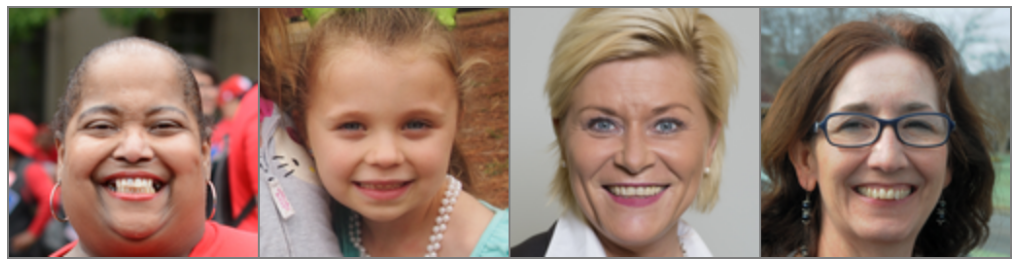

In [ ]:
show_images(faces)

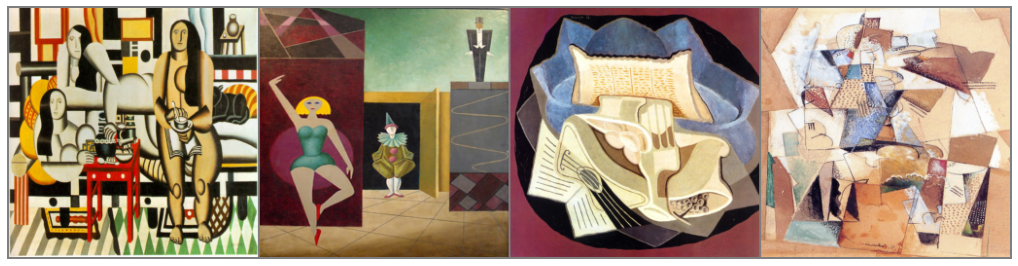

In [ ]:
show_images(style)

## F2V

In [ ]:
dataset_human_url = 'https://www.kaggle.com/datasets/greatgamedota/ffhq-face-data-set'
od.download(dataset_human_url)
#francescogiarrusso
#61ba928649038bef3323569574fd0bef

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: francescogiarrusso
Your Kaggle Key: ··········


100%|██████████| 1.97G/1.97G [00:20<00:00, 102MB/s]


In [ ]:
#Directory for train dataset
faces_dir= '/content/ffhq-face-data-set/thumbnails128x128'
style_dir='/content/gdrive/MyDrive/Colab Notebooks/VISIOPE/dataset/Nuovo_VanGogh'

In [ ]:
dataset = CustomDataset(faces_dir, style_dir,  transform)

In [ ]:
train_data, test_data = random_split(dataset, [0.8, 0.2])

In [ ]:
dataloader_train = DataLoader(train_data, batch_size, shuffle=True, pin_memory=True)
dataloader_test = DataLoader(test_data, batch_size_test, shuffle=False, pin_memory=True)

In [ ]:
faces, style = next(iter(dataloader_train))

In [ ]:
show_images(faces)

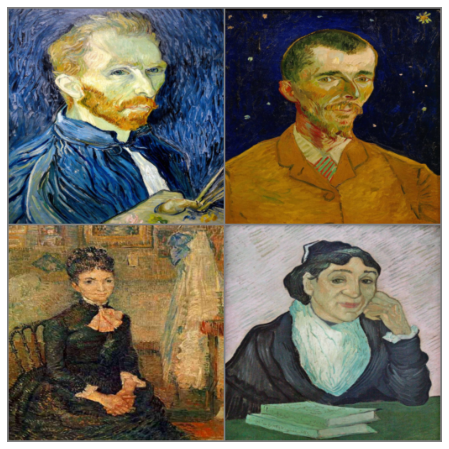

In [ ]:
show_images(style)

## F2W

In [ ]:
dataset_human_url = 'https://www.kaggle.com/datasets/greatgamedota/ffhq-face-data-set'
od.download(dataset_human_url)
#francescogiarrusso
#61ba928649038bef3323569574fd0bef

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: francescogiarrusso
Your Kaggle Key: ··········


100%|██████████| 1.97G/1.97G [00:18<00:00, 113MB/s]


In [ ]:
#Directory for train dataset
faces_dir= '/content/ffhq-face-data-set/thumbnails128x128'
style_dir='/content/gdrive/MyDrive/Colab Notebooks/VISIOPE/dataset/Nuovo_Warhol'

In [ ]:
dataset = CustomDataset(faces_dir, style_dir,  transform)

In [ ]:
train_data, test_data = random_split(dataset, [0.8, 0.2])

In [ ]:
dataloader_train = DataLoader(train_data, batch_size, shuffle=True, pin_memory=True)
dataloader_test = DataLoader(test_data, batch_size_test, shuffle=False, pin_memory=True)

In [ ]:
faces, style = next(iter(dataloader_train))

In [ ]:
show_images(faces)

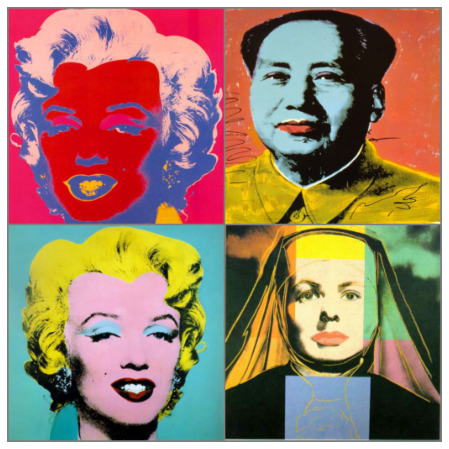

In [ ]:
show_images(style)

## L2I

In [ ]:
# Download dataset
dataset='https://www.kaggle.com/datasets/arnaud58/landscape-pictures'
od.download(dataset)
# francescogiarrusso
# 61ba928649038bef3323569574fd0bef

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: francescogiarrusso
Your Kaggle Key: ··········


100%|██████████| 620M/620M [00:05<00:00, 115MB/s]


In [ ]:
dataset='https://www.kaggle.com/datasets/robgonsalves/impressionistlandscapespaintings'
od.download(dataset)
# francescogiarrusso
# 61ba928649038bef3323569574fd0bef

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: francescogiarrusso
Your Kaggle Key: ··········


100%|██████████| 1.00G/1.00G [00:08<00:00, 132MB/s]


In [ ]:
#Directory for train dataset
landscape_dir= '/content/landscape-pictures'
style_dir='/content/impressionistlandscapespaintings/content/drive/MyDrive/impressionist_landscapes_resized_1024'

In [ ]:
dataset = CustomDataset(landscape_dir, style_dir,  transform)

In [ ]:
train_data, test_data = random_split(dataset, [0.8, 0.2])

In [ ]:
dataloader_train = DataLoader(train_data, batch_size, shuffle=True, pin_memory=True)
dataloader_test = DataLoader(test_data, batch_size_test, shuffle=False, pin_memory=True)

In [ ]:
landscape, style = next(iter(dataloader_train))

In [ ]:
show_images(landscape)

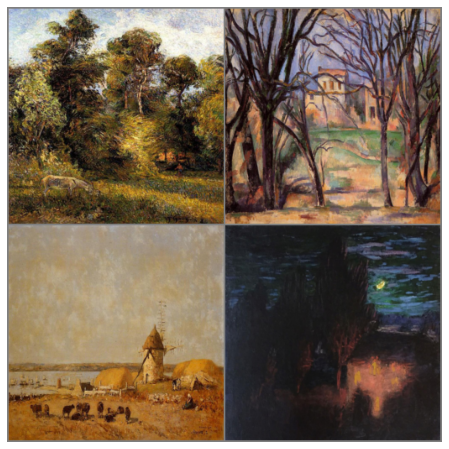

In [ ]:
show_images(style)

# CycleGan model

## Discriminator

In [ ]:
class DiscriminatorBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding, instancenorm=True):
    super(DiscriminatorBlock, self).__init__()
    if instancenorm: 
      self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, padding_mode='reflect'),
        nn.InstanceNorm2d(out_channels),
        nn.LeakyReLU(0.2, inplace=True)
        )
    else:
      self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, padding_mode='reflect'),
        nn.LeakyReLU(0.2, inplace=True)
        )
  def forward(self,x):
    return self.conv(x)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, d=64):
        super(Discriminator, self).__init__()
        self.block = nn.Sequential(
            DiscriminatorBlock(3, d, 4, 2, 1, instancenorm=False),
            DiscriminatorBlock(d, d*2, 4, 2, 1),
            DiscriminatorBlock(d*2, d*4, 4, 2, 1),
            DiscriminatorBlock(d*4, d*8, 4, 1, 1)
        )

        self.last = nn.Conv2d(d*8, 1, 4, 1, 1)
  
  def forward(self, x):
        x = self.block(x)
        x = self.last(x)
        
        return x

## Generator

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.InstanceNorm2d(channels),
        )

  def forward(self, x):
      return x + self.conv(x)

In [ ]:
class Downsample(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding, instancenorm=True):
    super(Downsample, self).__init__()
    if instancenorm: 
      self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, padding_mode='reflect'),
        nn.InstanceNorm2d(out_channels),
        nn.ReLU(inplace=True)
        )
    else:
      self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, padding_mode='reflect'),
        nn.ReLU(inplace=True)
        )

  def forward(self,x):
    return  self.conv(x)

class Upsample(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding, output_padding):
    super(Upsample, self).__init__()
    self.conv = nn.Sequential(
         nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride,padding, output_padding),
         nn.InstanceNorm2d(out_channels),
         nn.ReLU(inplace=True)
        )

  def forward(self, x):
    return  self.conv(x)



In [ ]:
class Generator(nn.Module):
  def __init__(self, n_residual, d=64):
        super(Generator, self).__init__()

        #Downsample

        generator = [Downsample(3,d,7,1,3)]
        generator += [Downsample(d, d*2, 3, 2, 1)]
        generator += [Downsample(d*2, d*4, 3, 2, 1)]
        
        #Residual
        for _ in range(n_residual):
            generator += [ResidualBlock(d*4)]
   
        #Upsample
        generator += [Upsample(d*4, d*2, 3, 2 ,1 ,1)]
        generator +=[Upsample(d*2, d, 3, 2, 1, 1)]

        #last
        generator += [nn.Conv2d(d, 3, kernel_size=7, stride=1, padding=3, padding_mode="reflect"), nn.Tanh()]   
        self.generator = nn.Sequential(*generator)
      
  def forward(self, x):
        return self.generator(x)
      

## Initialize

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [ ]:
# Initialize generator and discriminator
G_AB = Generator(n_residual_blocks)
G_BA = Generator(n_residual_blocks)
D_A = Discriminator()
D_B = Discriminator()


G_AB = G_AB.to(device)
G_BA = G_BA.to(device)
D_A = D_A.to(device)
D_B = D_B.to(device)

In [ ]:
# Initialize weights
G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)

In [ ]:
# Optimizers(Opt gen diverso da online)
optimizer_G = torch.optim.Adam(list(G_AB.parameters()) + list(G_BA.parameters()) , lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(D_A.parameters(),lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(),lr=lr, betas=(0.5, 0.999))

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_id = torch.nn.L1Loss()

criterion_GAN = criterion_GAN.to(device)
criterion_cycle = criterion_cycle.to(device)
criterion_id = criterion_id.to(device)

## Pretrained model

In [ ]:
# Load pretrained model f2c 
G_AB.load_state_dict(torch.load(f"{dir_checkpoint_cyclegan}/G_AB_f2c.pth"))
G_BA.load_state_dict(torch.load(f"{dir_checkpoint_cyclegan}/G_BA_f2c.pth"))
D_A.load_state_dict(torch.load(f"{dir_checkpoint_cyclegan}/D_A_f2c.pth"))
D_B.load_state_dict(torch.load(f"{dir_checkpoint_cyclegan}/D_B_f2c.pth"))

<All keys matched successfully>

In [ ]:
# Load pretrained model f2w 
G_AB.load_state_dict(torch.load(f"{dir_checkpoint_cyclegan}/G_AB_f2w.pth"))
G_BA.load_state_dict(torch.load(f"{dir_checkpoint_cyclegan}/G_BA_f2w.pth"))
D_A.load_state_dict(torch.load(f"{dir_checkpoint_cyclegan}/D_A_f2w.pth"))
D_B.load_state_dict(torch.load(f"{dir_checkpoint_cyclegan}/D_B_f2w.pth"))

<All keys matched successfully>

In [ ]:
# Load pretrained model f2v
G_AB.load_state_dict(torch.load(f"{dir_checkpoint_cyclegan}/G_AB_f2v.pth"))
G_BA.load_state_dict(torch.load(f"{dir_checkpoint_cyclegan}/G_BA_f2v.pth"))
D_A.load_state_dict(torch.load(f"{dir_checkpoint_cyclegan}/D_A_f2v.pth"))
D_B.load_state_dict(torch.load(f"{dir_checkpoint_cyclegan}/D_B_f2v.pth"))

In [ ]:
# Load pretrained model l2i (20 epoche)
G_AB.load_state_dict(torch.load(f"{dir_checkpoint_cyclegan}/G_AB_l2i.pth"))
G_BA.load_state_dict(torch.load(f"{dir_checkpoint_cyclegan}/G_BA_l2i.pth"))
D_A.load_state_dict(torch.load(f"{dir_checkpoint_cyclegan}/D_A_l2i.pth"))
D_B.load_state_dict(torch.load(f"{dir_checkpoint_cyclegan}/D_B_l2i.pth"))

<All keys matched successfully>

# Train

In [ ]:
def fit(data_train,data_test, epochs, start_idx):

  for epoch in range(epochs):
        losses_g = losses_id = losses_gan = losses_cyc = losses_disc = 0.0
        tqdm_bar = tqdm(data_train, desc=f'Training Epoch {epoch+start_idx+1} ', total=int(len(data_train)))
        for index, batch in enumerate(tqdm_bar):
          realA, realB = batch

          realA=realA.to(device)
          realB=realB.to(device)


          # Train Generators
          G_AB.train()
          G_BA.train()
          optimizer_G.zero_grad()

          # Identity loss
          id_A=G_BA(realA)
          id_B=G_AB(realB)
          loss_id_A = criterion_id(id_A, realA)
          loss_id_B = criterion_id(id_B, realB)
          loss_id = (loss_id_A + loss_id_B) / 2

          # GAN loss
          fakeA = G_BA(realB)
          fakeB = G_AB(realA)
          D_A_fake = D_A(fakeA)
          D_B_fake = D_B(fakeB)
          opposite_targets_A = torch.ones_like(D_A_fake)
          opposite_targets_B = torch.ones_like(D_B_fake)
          loss_AB = criterion_GAN(D_B_fake, opposite_targets_B)
          loss_BA = criterion_GAN(D_A_fake, opposite_targets_A)

          loss_GAN = (loss_AB + loss_BA) / 2
          
          # Cycle loss
          cycle_A = G_BA(fakeB)
          cycle_B = G_AB(fakeA)
          cycle_lossA=criterion_cycle(cycle_A,realA)
          cycle_lossB=criterion_cycle(cycle_B,realB)
          cycle_loss=(cycle_lossA+cycle_lossB)/2
          
          # Total loss
          loss_G = lambda_id * loss_id + loss_GAN + lambda_cyc * cycle_loss
          loss_G.backward()
          optimizer_G.step()

          # Train Discriminator A
          D_A.train()
          optimizer_D_A.zero_grad()

          D_A_real = D_A(realA)
          real_targets_A = torch.ones_like(D_A_real)
          D_A_real_loss = criterion_GAN(D_A_real,real_targets_A)

 
          fake_A = G_BA(realB)
          D_A_fake = D_A(fake_A.detach())
          fake_targets_A = torch.zeros_like(D_A_fake)
          D_A_fake_loss = criterion_GAN(D_A_fake, fake_targets_A)
  
          # Total loss Discriminator A
          loss_DA = (D_A_real_loss + D_A_fake_loss) / 2
          loss_DA.backward()
          optimizer_D_A.step()
 

          #Train Discriminator B
          D_B.train()
          optimizer_D_B.zero_grad()

          D_B_real = D_B(realB)
          real_targets_B = torch.ones_like(D_B_real)
          D_B_real_loss = criterion_GAN(D_B_real,real_targets_B)
     

          fake_B = G_AB(realA)
          D_B_fake = D_B(fake_B.detach())
          fake_targets_B = torch.zeros_like(D_B_fake)
          D_B_fake_loss = criterion_GAN(D_B_fake, fake_targets_B)


          # Total loss Discriminator B
          loss_DB = (D_B_real_loss + D_B_fake_loss) / 2
          loss_DB.backward()
          optimizer_D_B.step()

          # Total loss
          loss_D = (loss_DA + loss_DB)/2
          

          # Log Progress
          losses_g += loss_G.item()
          losses_disc += loss_D.item()
          tqdm_bar.set_postfix(Gen_loss=losses_g/(index+1), Disc_loss=losses_disc/(index+1))

        # Testing
        losses_g = losses_id = losses_gan = losses_cyc = losses_disc = 0.0
        tqdm_bar = tqdm(data_test, desc=f'Testing Epoch {epoch+start_idx+1} ', total=int(len(data_test)), colour='blue')
        for index, batch in enumerate(tqdm_bar):

           realA, realB = batch
           realA=realA.to(device)
           realB=realB.to(device)

           # Test Generators
           G_AB.eval()
           G_BA.eval()

           # Identity loss
           id_A=G_BA(realA)
           id_B=G_AB(realB)
           loss_id_A = criterion_id(id_A, realA)
           loss_id_B = criterion_id(id_B, realB)
           loss_id = (loss_id_A + loss_id_B) / 2

           # GAN loss
           fakeA = G_BA(realB)
           fakeB = G_AB(realA)
           D_A_fake = D_A(fakeA)
           D_B_fake = D_B(fakeB)
           opposite_targets_A = torch.ones_like(D_A_fake)
           opposite_targets_B = torch.ones_like(D_B_fake)
           loss_AB = criterion_GAN(D_B_fake, opposite_targets_B)
           loss_BA = criterion_GAN(D_A_fake, opposite_targets_A)

           loss_GAN = (loss_AB + loss_BA) / 2
        
           # Cycle loss
           cycle_A = G_BA(fakeB)
           cycle_B = G_AB(fakeA)
           cycle_lossA=criterion_cycle(cycle_A,realA)
           cycle_lossB=criterion_cycle(cycle_B,realB)
           cycle_loss=(cycle_lossA+cycle_lossB)/2

           # Total loss
           loss_G = lambda_id * loss_id + loss_GAN + lambda_cyc * cycle_loss

           # Test Discriminator A
           D_A.eval()
           # Real loss
           D_A_real = D_A(realA)
           real_targets_A = torch.ones_like(D_A_real)
           D_A_real_loss = criterion_GAN(D_A_real,real_targets_A)



           fake_A = G_BA(realB)
           D_A_fake = D_A(fake_A.detach())
           fake_targets_A = torch.zeros_like(D_A_fake)
           D_A_fake_loss = criterion_GAN(D_A_fake, fake_targets_A)
 

           # Total loss Discriminator A
           loss_DA = (D_A_real_loss + D_A_fake_loss) / 2


           # Test Discriminator B
           D_B.eval()
           D_B_real = D_B(realB)
           real_targets_B = torch.ones_like(D_B_real)
           D_B_real_loss = criterion_GAN(D_B_real,real_targets_B)



           fake_B = G_AB(realA)
           D_B_fake = D_B(fake_B.detach())          
           fake_targets_B = torch.zeros_like(D_B_fake)
           D_B_fake_loss = criterion_GAN(D_B_fake, fake_targets_B)


           # Total loss Discriminator B
           loss_DB = (D_B_real_loss + D_B_fake_loss) / 2

           # Total loss
           loss_D = (loss_DA + loss_DB) / 2
 
           losses_g += loss_G.item(); 
           losses_id += loss_id.item(); 
           losses_gan += loss_GAN.item(); 
           losses_cyc += cycle_loss.item()
           losses_disc += loss_D.item()
           tqdm_bar.set_postfix(Gen_loss=losses_g/(index+1), Disc_loss=losses_disc/(index+1)) 

           
           # Generate images
           realA = make_grid(realA, nrow=1, normalize=True)
           realB = make_grid(realB, nrow=1, normalize=True)
           fakeA = make_grid(fakeA, nrow=1, normalize=True)
           fakeB = make_grid(fakeB, nrow=1, normalize=True)
           image_grid = torch.cat((realA, fakeB, realB, fakeA), -1)
           save_image(image_grid, f"images/{epoch+start_index+1}.png", normalize=False)

        torch.save(G_AB.state_dict(), f"{dir_checkpoint_cyclegan}/G_AB_l2i.pth")   
        torch.save(G_BA.state_dict(), f"{dir_checkpoint_cyclegan}/G_BA_l2i.pth")
        torch.save(D_A.state_dict(), f"{dir_checkpoint_cyclegan}/D_A_l2i.pth")
        torch.save(D_B.state_dict(), f"{dir_checkpoint_cyclegan}/D_B_l2i.pth")




In [ ]:
run=fit(dataloader_train, dataloader_test, epochs, start_index)  

# Saving image folder

In [ ]:
from google.colab import files

In [ ]:
!zip -r /content/images.zip /content/images


In [ ]:
files.download('/content/images.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>